In [37]:
!pip install sastrawi --quiet

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import transformers
import string
import re
import random
import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
from tqdm import tqdm
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from transformers import logging
from keras.callbacks import EarlyStopping, ModelCheckpoint

# read data

In [39]:
# data = pd.read_csv('/kaggle/input/genshin/genshin.csv')
# data = data[['content', 'score']].rename(columns={'content': 'full_text'})
# data
data = pd.read_csv('/kaggle/input/accident/twitter_label_manual.csv')
data = data[['full_text', 'is_accident']].rename(columns={'is_accident': 'label'})
data

,full_text,label
0,"Rekaman CCTV Kecelakaan Motor di PIK, depan Ta...",1
1,"Tewaskan 346 Orang dalam 2 Kecelakaan, Boss Bo...",1
2,Anggota parlemen Taiwan juga berencana meningk...,0
3,C.Gerakan.bicara pertolongan pertama pada kece...,0
4,Asuransi mana nih??\n\nhttps://t.co/AJyABmimcY...,0
...,...,...
997,"""Jatuh cinta itu adalah sebuah kecelakaan yang...",0
998,Pesan nasi goreng depan lapaknya ada kecelakaa...,0
999,"Hati-hati, Lalin di Tol Purbaleunyi Baros KM 1...",1
1000,korang ada any idea tak macam mana nak bina sa...,0


In [40]:
# def pelabelan(score):
#     if score > 3:
#         return 1
#     else:
#         return 0
# data['label'] = data['score'].apply(pelabelan)
# data = data[['full_text','label']]
# data.head(10)

# clean data

In [41]:
stop_words = StopWordRemoverFactory().get_stop_words()
len(stop_words)

126

In [42]:
import emoji

def remove_emoji(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.EMOJI_DATA]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [43]:
def clean_data(text):
        result = text.lower()
        result = remove_emoji(result) #remove emoji
        result = re.sub('\n', ' ', result) #remove new line
        result = re.sub(r'@\w+', ' ', result) #remove user mention
        result = re.sub(r'http\S+', ' ', result) #remove link
        result = re.sub(r'\d+', '', result) #remove number
        result = result.translate(str.maketrans('', '', string.punctuation)) #remove punctuation
        result = ' '.join([word for word in result.split() if word not in stop_words]) #remove stopword

        return result.strip()

In [44]:
data['text'] = data['full_text'].apply(lambda x: clean_data(x))
data = data.drop(columns=['full_text'])
data

,label,text
0,1,rekaman cctv kecelakaan motor pik depan taman ...
1,1,tewaskan orang kecelakaan boss boeing minta maaf
2,0,anggota parlemen taiwan berencana meningkatkan...
3,0,cgerakanbicara pertolongan pertama kecelakaan ...
4,0,asuransi mana nih ppatk memberikan rincian sia...
...,...,...
997,0,jatuh cinta sebuah kecelakaan sangat indah seb...
998,0,pesan nasi goreng depan lapaknya kecelakaan au...
999,1,hatihati lalin tol purbaleunyi baros km km ara...
1000,0,korang any idea tak macam mana nak bina satu p...


In [45]:
data['label'].value_counts()

label
0    642
1    360
Name: count, dtype: int64

In [46]:
from statistics import mean

max_len = mean(data.astype('str').applymap(lambda x: len(x)).max())
print(f'Average text length: {max_len}')

Average text length: 132.5


/tmp/ipykernel_34/1345169955.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_len = mean(data.astype('str').applymap(lambda x: len(x)).max())


In [47]:
train_valid, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, validation_data = train_test_split(train_valid, test_size=0.1, random_state=42)
print(f'Train data size: {train_data.shape}')
print(f'Validation data size: {validation_data.shape}')
print(f'Test data size: {test_data.shape}')

Train data size: (720, 2)
Validation data size: (81, 2)
Test data size: (201, 2)


# tokenizer

In [48]:
def encode(tokenizer, data) :
    input_ids = []
    attention_masks = []
  
    for text in data['text']:
        encoded = tokenizer(text, max_length=128, padding='max_length')
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids), np.array(attention_masks)

In [49]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# pretrained list

In [50]:
pretrained_indobert = 'indolem/indobert-base-uncased'
pretrained_indobertweet = 'indolem/indobertweet-base-uncased'
pretrained_roberta_wiki = 'cahya/roberta-base-indonesian-522M'
pretrained_roberta_oscar = 'flax-community/indonesian-roberta-base'

# indo bert

In [51]:
from transformers import BertTokenizer

indobert_tokenizer  = BertTokenizer.from_pretrained(pretrained_indobert)

In [52]:
# split data

train_input_ids, train_attention_masks = encode(indobert_tokenizer, train_data)
validation_input_ids, validation_attention_masks = encode(indobert_tokenizer, validation_data)
test_input_ids, test_attention_masks = encode(indobert_tokenizer, test_data)

In [53]:
def indobert(model, dropout, learning_rate):
    input_ids = tf.keras.Input(shape=(128,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(128,), dtype='int32')
    
    output = model([input_ids,attention_masks])
    output = output[1]
    
    output = tf.keras.layers.Dense(32, activation='relu')(output)
    output = tf.keras.layers.Dropout(dropout)(output)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs=[input_ids,attention_masks], outputs=output)
    
    model.compile(
        Adam(learning_rate=learning_rate), 
        loss='binary_crossentropy', 
        metrics=['accuracy', f1, precision, recall])
    
    return model

In [54]:
from transformers import TFBertModel

indobert_pretrained_model = TFBertModel.from_pretrained(pretrained_indobert, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [55]:
indobert_model = indobert(indobert_pretrained_model, dropout=0.1, learning_rate=5e-5)
indobert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1105582   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   08         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

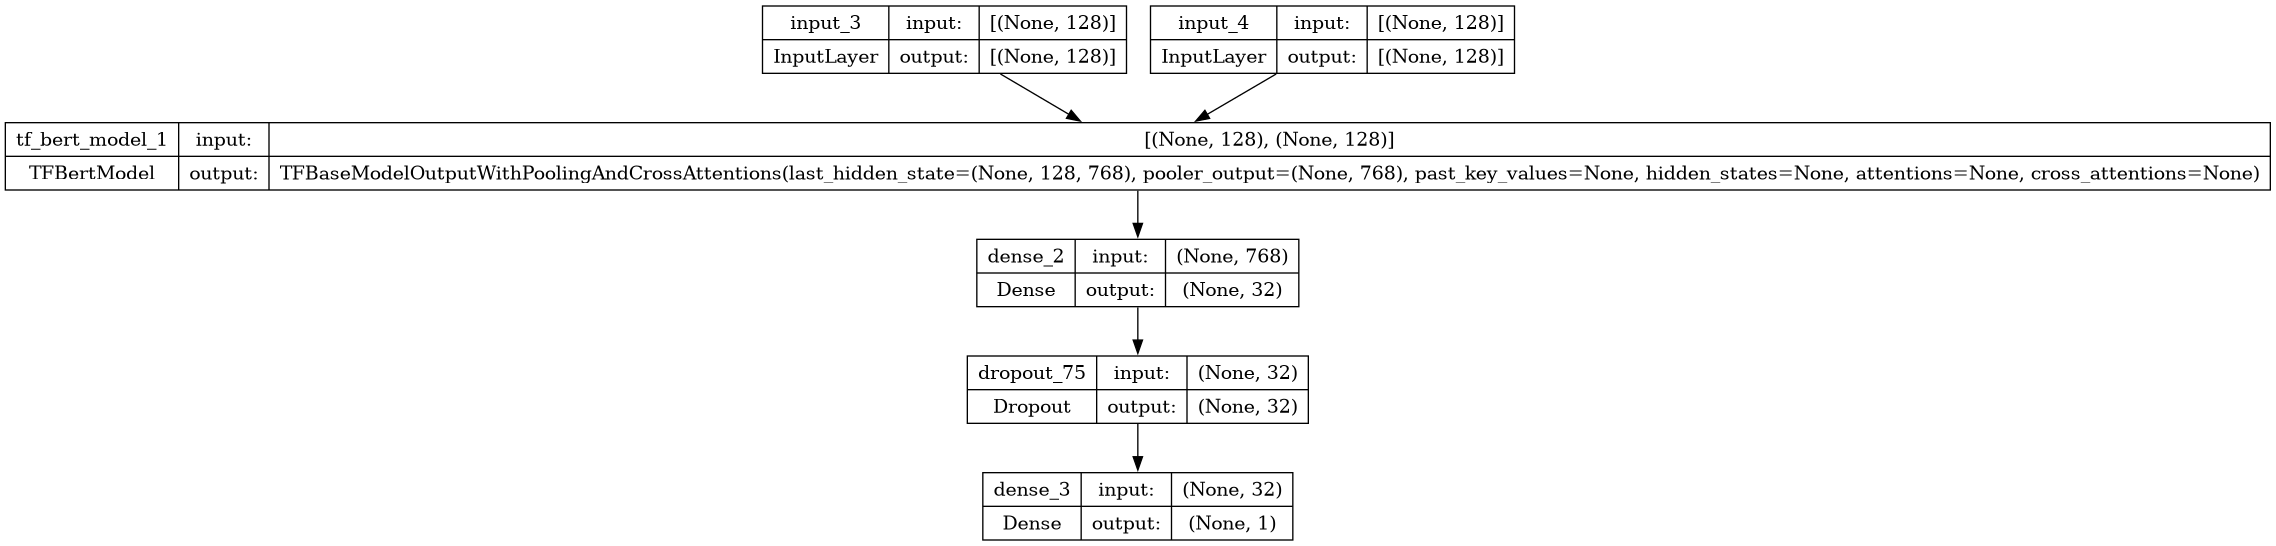

In [56]:
import os
from tensorflow.keras.utils import plot_model

path = 'illustration'
    
if not os.path.exists(path):
    os.makedirs(path)
    
plot_model(indobert_model, to_file=f'{path}/IndoBERT.png', expand_nested=True, show_shapes=True)

In [57]:
del(indobert_pretrained_model)
del(indobert_model)
keras.backend.clear_session()

In [58]:
train_targets = train_data['label'].values
validation_targets = validation_data['label'].values
test_targets = test_data['label'].values

In [60]:
learing_rate = [5e-5]
batch = [32]

batch_for_test_result = []
learing_rate_for_test_result = []
test_loss = []
test_accuracy = []
test_f1 = []
test_precision = []
test_recall = []

early_stopping = EarlyStopping(monitor='val_f1', patience=3, verbose=0, mode='max')

if not os.path.exists('results/models'):
    os.makedirs('results/models')

for b in batch:   
    for lr in learing_rate:
        print(f'Training IndoBERT Model (Batch Size = {b}, Learning Rate = {lr})')

        indobert_pretrained_model = TFBertModel.from_pretrained(pretrained_indobert, from_pt=True)
        indobert_model = indobert(indobert_pretrained_model, dropout=0.1, learning_rate=lr)
        
        save_best = ModelCheckpoint(
            f'results/models/indobert_batch={b}_lr={lr}.hdf5', 
            save_best_only=True, 
            save_weights_only=True,
            monitor='val_f1', 
            mode='max'
        )

        history = indobert_model.fit(
            [train_input_ids,train_attention_masks], 
            train_targets, 
            validation_data=([validation_input_ids, validation_attention_masks], validation_targets),
            callbacks=[early_stopping, save_best],
            epochs=10, 
            batch_size=b,
            verbose=1
        )

#         save_graph(history, lr, b, 'IndoBERT')
#         save_history(history, lr, b, 'IndoBERT')

        print(f'Testing IndoBERT Model (Batch Size = {b}, Learning Rate = {lr})')
        
        indobert_model.load_weights(f'results/models/indobert_batch={b}_lr={lr}.hdf5')
        
        evaluation = indobert_model.evaluate(
            [test_input_ids, test_attention_masks], 
            test_targets, 
            batch_size=b,
            verbose=1
        )

        batch_for_test_result.append(b)
        learing_rate_for_test_result.append(lr)
        test_loss.append(evaluation[0])
        test_accuracy.append(evaluation[1])
        test_f1.append(evaluation[2])
        test_precision.append(evaluation[3])
        test_recall.append(evaluation[4])

        del(indobert_pretrained_model)
        del(indobert_model)
        del(history)
        del(evaluation)
        keras.backend.clear_session()


test_result_df = pd.DataFrame({
    'Training Batch Size': batch_for_test_result,
    'Training Learning Rate': learing_rate_for_test_result, 
    'Test Loss': test_loss, 
    'Test Accuracy': test_accuracy,
    'Test F1-Score': test_f1,
    'Test Precision': test_precision,
    'Test Recall': test_recall,
})

path = f'results/evaluation'
    
if not os.path.exists(path):
    os.makedirs(path)

test_result_df.to_csv(f'{path}/IndoBERT.csv', index=False)

Training IndoBERT Model (Batch Size = 32, Learning Rate = 5e-05)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

Epoch 1/10
23/23 [==============================] - 55s 668ms/step - loss: 0.6029 - accuracy: 0.6528 - f1: 0.3657 - precision: 0.5015 - recall: 0.3711 - val_loss: 0.5567 - val_accuracy: 0.7284 - val_f1: 0.7331 - val_precision: 0.6873 - val_recall: 0.8444
Epoch 2/10
23/23 [==============================] - 12s 528ms/step - loss: 0.3691 - accuracy: 0.8278 - f1: 0.7537 - precision: 0.7901 - recall: 0.7750 - val_loss: 0.3597 - val_accuracy: 0.8642 - val_f1: 0.8396 - val_precision: 0.8297 - val_recall: 0.8722
Epoch 3/10
23/23 [==============================] - 12s 527ms/step - loss: 0.2200 - accuracy: 0.9194 - f1: 0.8869 - precision: 0.8928 - recall: 0.8903 - val_loss: 0.4425 - val_accuracy: 0.8519 - val_f1: 0.8429 - val_precision: 0.7875 - val_recall: 0.9333
Epoch 4/10
23/23 [==============================] - 12s 528ms/step - loss: 0.1659 - accuracy: 0.9375 - f1: 0.9151 - precision: 0.9100 - recall: 0.9255 - val_loss: 0.3698 - val_accuracy: 0.8765 - val_f1: 0.8445 - val_precision: 0.8553 -